# CIFAR-10 classification with a neural network
# Author: Alexey Gladyshev

In [14]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tqdm import trange

In [15]:
np.random.seed(47)
dataset_root_path = '/home/agladyshev/Documents/UNN/DL/Datasets/cifar-10-batches-py'
weights_path = os.path.join('./weights', 'Lenet5XXX_weights_51_acc.tar')

## 1. Load CIFAR-10 dataset and prepare data

In [16]:
class DataManager:
    def __init__(self, dataset_root_path, like_images=False):
        def get_data_batch(data_path):
            with open(data_path, 'rb') as fo:
                raw_train_data = pickle.load(fo, encoding='bytes')
            keys = list(raw_train_data.keys())
            return np.array(raw_train_data[keys[2]]), np.array(raw_train_data[keys[1]])

        train_data_1, train_labels_1 = get_data_batch(os.path.join(dataset_root_path, 'data_batch_1'))
        train_data_2, train_labels_2 = get_data_batch(os.path.join(dataset_root_path, 'data_batch_2'))
        train_data_3, train_labels_3 = get_data_batch(os.path.join(dataset_root_path, 'data_batch_3'))
        train_data_4, train_labels_4 = get_data_batch(os.path.join(dataset_root_path, 'data_batch_4'))
        train_data_5, train_labels_5 = get_data_batch(os.path.join(dataset_root_path, 'data_batch_5'))
        self.test_data, self.test_labels = get_data_batch(os.path.join(dataset_root_path, 'test_batch'))

        self.train_data = np.concatenate((train_data_1, train_data_2, train_data_3, train_data_4, train_data_5), axis=0)
        self.train_labels = np.concatenate((train_labels_1, train_labels_2, train_labels_3, train_labels_4, train_labels_5), axis=0)

        self.train_data = (self.train_data - np.mean(self.train_data, axis=0)) / np.std(self.train_data, axis=0)
        self.test_data = (self.test_data - np.mean(self.test_data, axis=0)) / np.std(self.test_data, axis=0)
        if like_images:
            self.train_data = self.train_data.reshape((len(self.train_data), 3, 32, 32))
            self.test_data = self.test_data.reshape((len(self.test_data), 3, 32, 32))

        self.train_data, self.val_data, self.train_labels, self.val_labels = train_test_split(self.train_data,
                                                                                              self.train_labels,
                                                                                              test_size=0.1,
                                                                                              random_state=47)

    def get_test_batch(self, batch_size):
        return self.train_data[:batch_size], self.train_labels[:batch_size]

    def get_train_data(self):
        return self.train_data, self.val_data, self.train_labels, self.val_labels

    def get_test_data(self):
        return self.test_data, self.test_labels


In [17]:
data_manager = DataManager(dataset_root_path, like_images=True)
X_train, X_val, y_train, y_val = data_manager.get_train_data()
X_test, y_test = data_manager.get_test_data()

## 2. NN implementation, layers, activations, loss functions and optimizer

В качестве оптимизатора используется `стохастический градиентный спуск`, он реализован в методе `backward()` у тех слоев, где это необходимо.

In [18]:
def xavier_initialization(shape, in_size, out_size):
    return np.random.uniform(-1, 1, size=shape) * np.sqrt(6. / (in_size + out_size))

In [19]:
class Layer:
    def __init__(self):
        self.name = 'layer'

    def forward(self, input):
        pass

    def backward(self, input, grad_output):
        pass

    def get_state(self):
        return self.name, None

    def set_state(self, params_dict):
        pass

    def __str__(self):
        return self.name

In [20]:
class ReLU(Layer):
    def __init__(self):
        super().__init__()
        self.name = 'ReLU'

    def forward(self, input):
        output = np.maximum(0, input)
        return output

    def backward(self, input, grad_output):
        relu_grad = input > 0
        return grad_output * relu_grad

In [21]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        super().__init__()
        self.name = 'Dense'
        self.learning_rate = learning_rate

        self.weights = xavier_initialization((input_units, output_units), input_units, output_units)
        self.biases = np.zeros(output_units)

    def forward(self, input):
        """
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases

    def backward(self, input, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)

        grad_weights = np.dot(input.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0)

        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input

    def get_state(self):
        return self.name, {'weights': self.weights, 'biases': self.biases}

    def set_state(self, params_dict):
        self.weights = params_dict['weights']
        self.biases = params_dict['biases']

In [22]:
class Flatten(Layer):
    def __init__(self):
        super().__init__()
        self.name = 'Flatten'

    def forward(self, input):
        n_samples, n_channels, height, width = input.shape
        return input.reshape((n_samples, n_channels * height * width))

    def backward(self, input, grad_output):
        return grad_output.reshape(input.shape)

In [23]:
class Dropout(Layer):
    def __init__(self, p):
        super().__init__()
        self.name = 'Dropout'
        self.p = p
        self.__mask_cache = None

    def forward(self, input):
        self.__mask_cache = np.random.binomial(1, self.p, size=input.shape) / self.p
        out = input * self.__mask_cache
        return out

    def backward(self, input, grad_output):
        return grad_output * self.__mask_cache

In [24]:
def running_average(running, new, gamma=.9):
    return gamma * running + (1. - gamma) * new


class BatchNormalization(Layer):
    def __init__(self, train_mode=True, learning_rate=0.1):
        super().__init__()
        self.name = 'BatchNormalization'
        self.train_mode = train_mode
        self.learning_rate = learning_rate

        self.gamma = 1
        self.beta = 0

        self.__eps = 0.0000001
        self.__running_mean = 0
        self.__running_var = 1
        self.__input_norm = None
        self.__batch_mean = None
        self.__batch_var = None

    def forward(self, input):
        self.__batch_mean = np.mean(input, axis=0)
        self.__batch_var = np.var(input, axis=0)
        self.__running_mean = running_average(self.__running_mean, self.__batch_mean)
        self.__running_var = running_average(self.__running_var, self.__batch_var)

        if self.train_mode:
            self.__input_norm = (input - self.__batch_mean) / np.sqrt(self.__batch_var + self.__eps)
            out = self.gamma * self.__input_norm + self.beta
        else:
            input_norm = (input - self.__running_mean) / np.sqrt(self.__running_var + self.__eps)
            out = self.gamma * input_norm + self.beta

        return out

    def backward(self, input, grad_output):
        n = input.shape[0]
        d = input.shape[1]

        input_mu = input - self.__batch_mean
        std_inv = 1. / np.sqrt(self.__batch_var + self.__eps)

        grad_input_norm = grad_output * self.gamma
        grad_var = np.sum(grad_input_norm * input_mu, axis=0) * -.5 * std_inv ** 3
        grad_mu = np.sum(grad_input_norm * -std_inv, axis=0) + grad_var * np.mean(-2. * input_mu, axis=0)

        grad_input = (grad_input_norm * std_inv) + (grad_var * 2 * input_mu / n) + (grad_mu / n)
        grad_gamma = np.sum(grad_output * self.__input_norm, axis=0)
        grad_beta = np.sum(grad_output, axis=0)

        self.gamma = self.gamma - self.learning_rate * grad_gamma
        self.beta = self.beta - self.learning_rate * grad_beta

        return grad_input

    def get_state(self):
        return self.name, {'gamma': self.gamma, 'beta': self.beta}

    def set_state(self, params_dict):
        self.gamma = params_dict['gamma']
        self.beta = params_dict['beta']

In [25]:
def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
    N, C, H, W = x_shape
    assert (H + 2 * padding - field_height) % stride == 0
    assert (W + 2 * padding - field_height) % stride == 0
    out_height = int((H + 2 * padding - field_height) / stride + 1)
    out_width = int((W + 2 * padding - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return k.astype(int), i.astype(int), j.astype(int)


def im2col_indices(x, field_height, field_width, padding=1, stride=1):
    p = padding
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

    k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding, stride)

    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    return cols


def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1, stride=1):
    N, C, H, W = x_shape
    H_padded, W_padded = H + 2 * padding, W + 2 * padding
    x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding, stride)
    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
    if padding == 0:
        return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]

In [26]:
class Conv(Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, learning_rate=0.1):
        super().__init__()
        self.name = 'Conv'
        self.learning_rate = learning_rate
        self.stride = stride
        self.padding = padding

        self.filters = xavier_initialization((out_channels, in_channels, kernel_size[0], kernel_size[1]), in_channels, out_channels)
        self.biases = np.zeros(out_channels)

        self.input_col = None

    def forward(self, input):
        """
        input shape: [batch, in_channels, in_height, in_width]
        output shape: [batch, out_channels, ..., ...]
        """
        n_filters, d_filter, h_filter, w_filter = self.filters.shape
        n_x, d_x, h_x, w_x = input.shape
        h_out = int((h_x - h_filter + 2 * self.padding) / self.stride) + 1
        w_out = int((w_x - w_filter + 2 * self.padding) / self.stride) + 1

        self.input_col = im2col_indices(input, h_filter, w_filter, padding=self.padding, stride=self.stride)
        filters_col = self.filters.reshape(n_filters, -1)

        out = np.dot(filters_col, self.input_col) + self.biases.reshape(-1, 1)
        out = out.reshape(n_filters, h_out, w_out, n_x)
        out = out.transpose(3, 0, 1, 2)

        return out

    def backward(self, input, grad_output):
        n_filters, d_filter, h_filter, w_filter = self.filters.shape

        grad_biases = np.sum(grad_output, axis=(0, 2, 3))

        grad_output_reshaped = grad_output.transpose(1, 2, 3, 0).reshape(n_filters, -1)
        grad_filters = np.dot(grad_output_reshaped, self.input_col.T)
        grad_filters = grad_filters.reshape(self.filters.shape)

        filters_reshaped = self.filters.reshape(n_filters, -1)
        grad_input_col = np.dot(filters_reshaped.T, grad_output_reshaped)
        grad_input = col2im_indices(grad_input_col, input.shape, h_filter, w_filter, padding=self.padding, stride=self.stride)

        self.filters = self.filters - self.learning_rate * grad_filters
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input

    def get_state(self):
        return self.name, {'filters': self.filters, 'biases': self.biases}

    def set_state(self, params_dict):
        self.filters = params_dict['filters']
        self.biases = params_dict['biases']

In [27]:
class PoolingLayer(Layer):
    def __init__(self, name, size=2, stride=2):
        super().__init__()
        self.name = name
        self.size = size
        self.stride = stride

        self.forward_pool_function = None
        self.backward_pool_function = None

        self.__input_reshaped = None
        self.__input_col = None
        self.__max_idx_cache = None

    def forward(self, input):
        n, d, h, w = input.shape
        h_out = int((h - self.size) / self.stride) + 1
        w_out = int((w - self.size) / self.stride) + 1

        self.__input_reshaped = input.reshape(n * d, 1, h, w)
        self.__input_col = im2col_indices(self.__input_reshaped, self.size, self.size, padding=0, stride=self.stride)

        out, self.__max_idx_cache = self.forward_pool_function(self.__input_col)
        out = out.reshape(h_out, w_out, n, d)
        out = out.transpose(2, 3, 0, 1)

        return out

    def backward(self, input, grad_output):
        n, d, w, h = input.shape

        grad_input_col = np.zeros_like(self.__input_col)
        grad_output_col = grad_output.transpose(2, 3, 0, 1).ravel()

        grad_input = self.backward_pool_function(grad_input_col, grad_output_col, self.__max_idx_cache)
        grad_input = col2im_indices(grad_input, (n * d, 1, h, w), self.size, self.size, padding=0, stride=self.stride)
        grad_input = grad_input.reshape(input.shape)

        return grad_input

In [28]:
def forward_max_pool(input_col):
    max_idx = np.argmax(input_col, axis=0)
    out = input_col[max_idx, range(max_idx.size)]
    return out, max_idx


def backward_max_pool(grad_input_col, grad_output_col, max_idx_cache):
    grad_input_col[max_idx_cache, range(grad_output_col.size)] = grad_output_col
    return grad_input_col


class MaxPool(PoolingLayer):
    def __init__(self, size=2, stride=2):
        super().__init__('MaxPool', size=size, stride=stride)
        self.forward_pool_function = forward_max_pool
        self.backward_pool_function = backward_max_pool

In [29]:
class SoftmaxCCE:
    @staticmethod
    def compute_loss(logits, reference_answers):
        logits_for_answers = logits[np.arange(len(logits)), reference_answers]
        xentropy = -logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))
        return xentropy

    @staticmethod
    def compute_grad(logits, reference_answers):
        ones_for_answers = np.zeros_like(logits)
        ones_for_answers[np.arange(len(logits)), reference_answers] = 1
        softmax = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return (- ones_for_answers + softmax) / logits.shape[0]

## 2.2. Model implementation

In [30]:
class Model:
    def __init__(self):
        self.name = 'BaseNet'
        self.learning_rate = 0.1
        self.network = None

        self.__accuracy = 0.

    def train_on_batch(self, X, y, loss_function):
        layer_activations = self.__forward(X)
        layer_inputs = [X] + layer_activations
        logits = layer_activations[-1]

        loss = loss_function.compute_loss(logits, y)
        loss_grad = loss_function.compute_grad(logits, y)

        current_grad = loss_grad
        for layer_ind in reversed(range(len(self.network))):
            current_grad = self.network[layer_ind].backward(layer_inputs[layer_ind], current_grad)

        return np.mean(loss)

    def predict(self, X, batch_step=1000):
        n_iterations = 1 + int(len(X) / batch_step)
        result = np.array([], dtype=int)
        for iteration in range(n_iterations):
            start_ind = batch_step * iteration
            result = np.append(result, self.__predict_on_batch(X[start_ind:min(start_ind + batch_step, len(X)), :]))
        return result

    def save_state_dict(self, accuracy, save_root_path='.'):
        if accuracy >= self.__accuracy:
            self.__accuracy = accuracy
            model_state = {}
            for layer_ind, layer in enumerate(self.network):
                layer_name, params_dict = layer.get_state()
                model_state[layer_ind] = {'layer_name': layer_name, 'params_dict': params_dict}

            with open(os.path.join(save_root_path, '{}_weights.tar'.format(self.name)), 'wb') as handle:
                pickle.dump(model_state, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def load_state_dict(self, weights_path):
        with open(weights_path, 'rb') as handle:
            model_state = pickle.load(handle)
        for layer_ind, layer_state_dict in model_state.items():
            layer_params = layer_state_dict['params_dict']
            if layer_params is not None:
                self.network[layer_ind].set_state(layer_params)

    def __forward(self, X):
        input = X
        activations = []
        for layer in self.network:
            input = layer.forward(input)
            activations.append(input)
        return activations

    def __predict_on_batch(self, X):
        logits = self.__forward(X)[-1]
        return logits.argmax(axis=-1)

In [31]:
class NoName(Model):
    def __init__(self, learning_rate):
        super().__init__()
        self.name = 'NoName'
        self.learning_rate = learning_rate

        self.network = []
        self.network.append(Conv(3, 64, (3, 3), learning_rate=learning_rate))
        self.network.append(ReLU())
        self.network.append(MaxPool(2, 1))
        self.network.append(BatchNormalization())

        self.network.append(Conv(64, 128, (3, 3), learning_rate=learning_rate))
        self.network.append(ReLU())
        self.network.append(MaxPool(2, 1))
        self.network.append(BatchNormalization())

        self.network.append(Conv(128, 256, (3, 3), learning_rate=learning_rate))
        self.network.append(ReLU())
        self.network.append(MaxPool(2, 1))
        self.network.append(BatchNormalization())

        self.network.append(Flatten())

        self.network.append(Dense(135424, 128))
        self.network.append(ReLU())
        self.network.append(Dropout(0.7))
        self.network.append(BatchNormalization())

        self.network.append(Dense(128, 512))
        self.network.append(ReLU())
        self.network.append(Dropout(0.7))
        self.network.append(BatchNormalization())

        self.network.append(Dense(512, 1024))
        self.network.append(ReLU())
        self.network.append(Dropout(0.7))
        self.network.append(BatchNormalization())

        self.network.append(Dense(1024, 10))

## 3. Check correctness

In [32]:
network = NoName(learning_rate=0.1)

Epoch 0
Loss:  3.333077163854842
Train accuracy:  0.3
Epoch 1
Loss:  2.577919292553527
Train accuracy:  0.8
Epoch 2
Loss:  0.6182426293711744
Train accuracy:  0.9
Epoch 3
Loss:  0.5399795269807296
Train accuracy:  1.0
Epoch 4
Loss:  0.22149153222401816
Train accuracy:  1.0


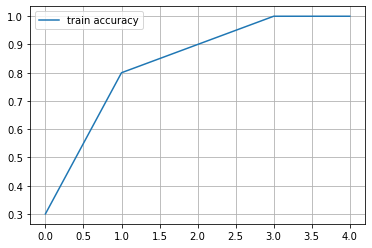

In [33]:
test_x_batch, test_y_batch = data_manager.get_test_batch(batch_size=10)

train_log = []
for epoch in range(5):
    loss = network.train_on_batch(test_x_batch, test_y_batch, SoftmaxCCE)
    train_log.append(np.mean(network.predict(test_x_batch, batch_step=32) == test_y_batch))
    print("Epoch", epoch)
    print("Loss: ", loss)
    print("Train accuracy: ", train_log[-1])

plt.plot(train_log, label='train accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

## 4. Experiments

In [8]:
network.load_state_dict(weights_path)

In [9]:
pred = network.predict(X_test, batch_step=32)

In [10]:
print('Test accuracy: ', accuracy_score(pred, y_test))

Test accuracy:  0.4614


In [11]:
print(confusion_matrix(pred, y_test))

[[371  23  44  31  23  10  12  14  67  25]
 [ 47 556  28  23  21  15  34  16  73 148]
 [ 89  13 249  54  81  71  44  41  15  22]
 [  9  11  49 156  35  82  42  31  18  20]
 [ 30   7 175  74 355  87  78  91  18   4]
 [ 29  21 149 327 115 510  57 136  27  24]
 [ 20  23 135 177 181  90 652  47  13  31]
 [ 35  22  75  56 118  84  26 518   9  37]
 [290  91  63  41  48  15  20  19 662 104]
 [ 80 233  33  61  23  36  35  87  98 585]]


## 5. Results
### The best NN architecture


### Learning rate strategy and batch size


### Data augmentations


### The best model test accuracy

